# Crime Type Prediction

In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold 
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
import numpy as np
from sklearn import preprocessing
import matplotlib.pyplot as plt
from collections import Counter

## Reading SF Dataset & Preprocessing

### Kaggle - Original

In [55]:
dataset_name = 'SF 2003-2015 Train.csv'
crime_df_ = pd.read_csv(dataset_name)
crime_df_ = crime_df_.drop(['Address', 'X', 'Y'], axis=1)
crime_df_ = crime_df_.dropna()

crime_df_['Year'] = crime_df_['Dates'].str.split('-').str[0].astype('int64')
crime_df_['Month'] = crime_df_['Dates'].str.split('-').str[1].astype('int64')
crime_df_['Hour'] = crime_df_['Dates'].str.split('-').str[2].str.split(' ').str[1].str.split(':').str[0].astype('int64')

crime_df_ = crime_df_[crime_df_['Year'] >= 2003]
crime_df_ = crime_df_[crime_df_['Year'] <= 2015]

"""
crime_df_.loc[crime_df_['Category'].str.contains('LOITERING'), 'Category'] = 'Infraction'
crime_df_.loc[crime_df_['Category'].str.contains('RUNAWAY|FAMILY OFFENSES|TREA|PORNOGRAPHY/OBSCENE MAT|GAMBLING|EMBEZZLEMENT|BAD CHECKS|SUICIDE|MISSING PERSON|DRUG/NARCOTIC|DRIVING UNDER THE INFLUENCE|LIQUOR LAWS|DISORDERLY CONDUCT|BRIBERY|RECOVERED VEHICLE|PROSTITUTION|SECONDARY CODES|STOLEN PROPERTY|FORGERY/COUNTERFEITING|WARRANTS|TRESPASS|SUSPICIOUS OCC|OTHER OFFENSES|DRUNKENNESS|NON-CRIMINAL'), 'Category'] = 'Misdemeanor'
crime_df_.loc[crime_df_['Category'].str.contains('ASSAULT|VEHICLE THEFT|BURGLARY|FRAUD|LARCENY/THEFT|SEX OFFENSES NON FORCIBLE|ARSON|SEX OFFENSES FORCIBLE|KIDNAPPING|VANDALISM|EXTORTION|WEAPON LAWS|ROBBERY'), 'Category'] = 'Felony'
"""

crime_df_ = crime_df_.drop(['Dates', 'Descript', 'Year'], axis=1)
crime_df_

,Category,DayOfWeek,PdDistrict,Resolution,Month,Hour
0,WARRANTS,Wednesday,NORTHERN,"ARREST, BOOKED",5,23
1,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",5,23
2,OTHER OFFENSES,Wednesday,NORTHERN,"ARREST, BOOKED",5,23
3,LARCENY/THEFT,Wednesday,NORTHERN,NONE,5,23
4,LARCENY/THEFT,Wednesday,PARK,NONE,5,23
...,...,...,...,...,...,...
878044,ROBBERY,Monday,TARAVAL,NONE,1,0
878045,LARCENY/THEFT,Monday,INGLESIDE,NONE,1,0
878046,LARCENY/THEFT,Monday,SOUTHERN,NONE,1,0
878047,VANDALISM,Monday,SOUTHERN,NONE,1,0


### Kaggle - Enhancement

In [22]:
dataset_name = 'SF 2003-2015 Train.csv'
crime_df_ = pd.read_csv(dataset_name)
crime_df_ = crime_df_.drop(['Address', 'X', 'Y'], axis=1)
crime_df_ = crime_df_.dropna()

crime_df_['Year'] = crime_df_['Dates'].str.split('-').str[0].astype('int64')
crime_df_['Month'] = crime_df_['Dates'].str.split('-').str[1].astype('int64')
crime_df_['Day'] = crime_df_['Dates'].str.split('-').str[2].str.split().str[0].astype('int64')
crime_df_['Hour'] = crime_df_['Dates'].str.split('-').str[2].str.split(' ').str[1].str.split(':').str[0].astype('int64')

crime_df_ = crime_df_[crime_df_['Year'] >= 2003]
crime_df_ = crime_df_[crime_df_['Year'] <= 2015]

crime_df_.loc[crime_df_['Category'].str.contains('LOITERING'), 'Category'] = 'Infraction'
crime_df_.loc[crime_df_['Category'].str.contains('RUNAWAY|FAMILY OFFENSES|TREA|PORNOGRAPHY/OBSCENE MAT|GAMBLING|EMBEZZLEMENT|BAD CHECKS|SUICIDE|MISSING PERSON|DRUG/NARCOTIC|DRIVING UNDER THE INFLUENCE|LIQUOR LAWS|DISORDERLY CONDUCT|BRIBERY|RECOVERED VEHICLE|PROSTITUTION|SECONDARY CODES|STOLEN PROPERTY|FORGERY/COUNTERFEITING|WARRANTS|TRESPASS|SUSPICIOUS OCC|OTHER OFFENSES|DRUNKENNESS|NON-CRIMINAL'), 'Category'] = 'Misdemeanor'
crime_df_.loc[crime_df_['Category'].str.contains('ASSAULT|VEHICLE THEFT|BURGLARY|FRAUD|LARCENY/THEFT|SEX OFFENSES NON FORCIBLE|ARSON|SEX OFFENSES FORCIBLE|KIDNAPPING|VANDALISM|EXTORTION|WEAPON LAWS|ROBBERY'), 'Category'] = 'Felony'

hour = ['0'+str(x) if len(str(x))==1 else str(x) for x in crime_df_['Hour']]
crime_df_['Hour'] = hour

crime_df_.loc[(crime_df_['Hour'].astype(str) >= '05') & (crime_df_['Hour'].astype(str) < '12'), 'DayGroup'] = 'Morning'
crime_df_.loc[(crime_df_['Hour'].astype(str) >= '12') & (crime_df_['Hour'].astype(str) < '17'), 'DayGroup'] = 'Afternoon'
crime_df_.loc[(crime_df_['Hour'].astype(str) >= '17') & (crime_df_['Hour'].astype(str) < '21'), 'DayGroup'] = 'Evening'
crime_df_.loc[(crime_df_['Hour'].astype(str) >= '21') & (crime_df_['Hour'].astype(str) < '24'), 'DayGroup'] = 'Night'
crime_df_.loc[(crime_df_['Hour'].astype(str) >= '00') & (crime_df_['Hour'].astype(str) < '05'), 'DayGroup'] = 'Night'

crime_df_.loc[(crime_df_['Month'] == 1) & (crime_df_['Day'] == 1), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 1) & (crime_df_['Day'] == 18), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 2) & (crime_df_['Day'] == 12), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 2) & (crime_df_['Day'] == 15), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 5) & (crime_df_['Day'] == 31), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 6) & (crime_df_['Day'] == 19), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 7) & (crime_df_['Day'] == 5), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 9) & (crime_df_['Day'] == 6), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 10) & (crime_df_['Day'] == 11), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 11) & (crime_df_['Day'] == 11), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 11) & (crime_df_['Day'] == 25), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 12) & (crime_df_['Day'] == 24), 'IsHoliday'] = 'Holiday'
crime_df_.loc[(crime_df_['Month'] == 12) & (crime_df_['Day'] == 31), 'IsHoliday'] = 'Holiday'
crime_df_.loc[crime_df_['IsHoliday'] != 'Holiday', 'IsHoliday'] = 'Not Holiday'

crime_df_.loc[(crime_df_['Month'] >= 3) & (crime_df_['Month'] <= 5), 'Season'] = 'Spring'
crime_df_.loc[(crime_df_['Month'] >= 6) & (crime_df_['Month'] <= 8), 'Season'] = 'Summer'
crime_df_.loc[(crime_df_['Month'] >= 9) & (crime_df_['Month'] <= 11), 'Season'] = 'Autumn'
crime_df_.loc[(crime_df_['Month'] == 12) | (crime_df_['Month'] <= 1) | (crime_df_['Month'] <= 2), 'Season'] = 'Winter'

crime_df_.loc[crime_df_['DayOfWeek'].str.contains('Monday|Tuesday|Wednesday|Thursday|Friday'), 'WeekGroup'] = 'Weekday'
crime_df_.loc[crime_df_['DayOfWeek'].str.contains('Saturday|Sunday'), 'WeekGroup'] = 'Weekend'

crime_df_ = crime_df_.drop(['IsHoliday', 'Dates', 'Descript', 'DayOfWeek', 'Hour', 'Month', 'Day'], axis=1)
crime_df_

,Category,PdDistrict,Resolution,Year,DayGroup,Season,WeekGroup
0,Misdemeanor,NORTHERN,"ARREST, BOOKED",2015,Night,Spring,Weekday
1,Misdemeanor,NORTHERN,"ARREST, BOOKED",2015,Night,Spring,Weekday
2,Misdemeanor,NORTHERN,"ARREST, BOOKED",2015,Night,Spring,Weekday
3,Felony,NORTHERN,NONE,2015,Night,Spring,Weekday
4,Felony,PARK,NONE,2015,Night,Spring,Weekday
...,...,...,...,...,...,...,...
878044,Felony,TARAVAL,NONE,2003,Night,Winter,Weekday
878045,Felony,INGLESIDE,NONE,2003,Night,Winter,Weekday
878046,Felony,SOUTHERN,NONE,2003,Night,Winter,Weekday
878047,Felony,SOUTHERN,NONE,2003,Night,Winter,Weekday


In [3]:
def pieChart(df, columnName,titleName):
    dictionary = dict(Counter(df[columnName]))

    sumValues = sum(dictionary.values())
    
    labels = [key+' - '+str(round(value/sumValues*100,2))+'%' for key,value in dictionary.items()]   #labels
    values = [x for x in dictionary.values()] #values

    patches, texts = plt.pie(values, startangle=90)
    plt.legend(patches, labels, bbox_to_anchor=(1,0), loc="lower right")
    # Set aspect ratio to be equal so that pie is drawn as a circle.
    plt.axis('equal')
    plt.tight_layout()
    plt.title("\nPie Chart for "+titleName)
    plt.show()

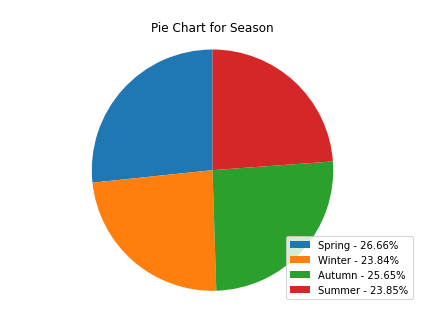

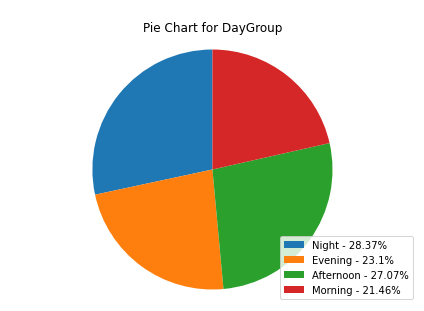

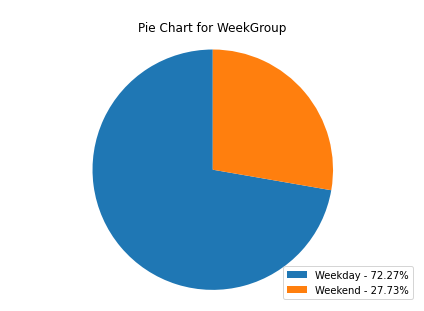

In [4]:
pieChart(crime_df_, 'Season','Season')
pieChart(crime_df_, 'DayGroup','DayGroup')
pieChart(crime_df_, 'WeekGroup','WeekGroup')

### Preparing Dataframe

In [23]:
crime_df_prediction = crime_df_.copy()

crime_df_prediction = crime_df_prediction.sort_values('Year')
crime_df_prediction = crime_df_prediction.drop(['Year'], axis=1)
crime_df_prediction

,Category,PdDistrict,Resolution,DayGroup,Season,WeekGroup
878048,Misdemeanor,BAYVIEW,NONE,Night,Winter,Weekday
828776,Felony,TENDERLOIN,NONE,Afternoon,Autumn,Weekday
828777,Misdemeanor,TENDERLOIN,NONE,Afternoon,Autumn,Weekday
828778,Felony,INGLESIDE,"ARREST, BOOKED",Afternoon,Autumn,Weekday
828779,Misdemeanor,CENTRAL,NONE,Afternoon,Autumn,Weekday
...,...,...,...,...,...,...
18394,Misdemeanor,PARK,"ARREST, BOOKED",Night,Winter,Weekday
18395,Felony,PARK,"ARREST, BOOKED",Night,Winter,Weekday
18396,Misdemeanor,PARK,"ARREST, BOOKED",Night,Winter,Weekday
18398,Misdemeanor,INGLESIDE,"ARREST, BOOKED",Night,Winter,Weekday


In [24]:
features = ['Resolution', 'PdDistrict', 'DayGroup', 'Season', 'WeekGroup']
# features = ['PdDistrict', 'DayGroup', 'Season', 'WeekGroup']
# features = ['Resolution', 'DayOfWeek', 'PdDistrict', 'Hour', 'Month', 'Year']
# features = ['Resolution', 'DayOfWeek', 'PdDistrict', 'Hour', 'Month']

one_hot_encoded_df = pd.get_dummies(crime_df_prediction[features])

variance_threshold_df = one_hot_encoded_df.T[one_hot_encoded_df.var() > 0.05].T
na_filled_df = variance_threshold_df.fillna(0)

na_filled_df


,"Resolution_ARREST, BOOKED","Resolution_ARREST, CITED",Resolution_NONE,PdDistrict_BAYVIEW,PdDistrict_CENTRAL,PdDistrict_INGLESIDE,PdDistrict_MISSION,PdDistrict_NORTHERN,PdDistrict_PARK,PdDistrict_SOUTHERN,...,DayGroup_Afternoon,DayGroup_Evening,DayGroup_Morning,DayGroup_Night,Season_Autumn,Season_Spring,Season_Summer,Season_Winter,WeekGroup_Weekday,WeekGroup_Weekend
878048,0,0,1,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0
828776,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
828777,0,0,1,0,0,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
828778,1,0,0,0,0,1,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
828779,0,0,1,0,1,0,0,0,0,0,...,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18394,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
18395,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
18396,1,0,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,1,1,0
18398,1,0,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,0,1,1,0


In [25]:
#creating labelEncoder
le = preprocessing.LabelEncoder()

na_filled_df['Category'] = le.fit_transform(crime_df_prediction['Category'])

data_matrix = na_filled_df.drop(columns=["Category"])
data_label = na_filled_df["Category"].values  # Separate the target values

## Splitting Dataset into Training Set and Test Set (Obj. 3)

In [26]:
na_filled_df = na_filled_df.reset_index(drop=True)

na_filled_df_train = na_filled_df.head(int(len(na_filled_df)*0.4))
na_filled_df_test = na_filled_df.tail(int(len(na_filled_df)*0.2))

na_filled_df_train_x = na_filled_df_train.drop(columns=["Category"])
na_filled_df_train_y = na_filled_df_train['Category']

na_filled_df_test_x = na_filled_df_test.drop(columns=["Category"])
na_filled_df_test_y = na_filled_df_test['Category']

## Splitting Dataset into Training Set and Test Set (Obj. 1)

In [17]:
# Splitting the dataset into train and test data respectively (80% Training data, 20% Test data)
X_train, X_test, y_train, y_test = train_test_split(data_matrix, data_label, test_size=0.2)

## Developing Models and Evaluating Them

- Predict Crime Type (Infraction, Misdeamonour or Felony)
- Evaluate models using k-Fold Cross Validation

In [18]:
def k_fold_cross_val(k, model, X, y, score):
    """ Function that performs cross validation """

    cv = KFold(n_splits=k, shuffle=True)

    # evaluate model
    scores = cross_val_score(model, X, y, scoring=score, cv=cv, n_jobs=-1)
    # scores = cross_validate(clf, data_matrix, data_label, scoring={'accuracy', 'f1_macro'}, cv=cv, n_jobs=-1)

    # report performance
    print('F-1 weighted average: %.3f having a standard deviation of %.3f' % (np.mean(scores), np.std(scores)))

In [19]:
k = 10
score = 'f1_weighted'

### Gaussian Classifier

In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(na_filled_df_train_x, na_filled_df_train_y)

#Predict the response for test dataset
y_pred_gnb = gnb.predict(na_filled_df_test_x)

# Outputting Classification Report for GaussianNB model
print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_gnb)}")

k_fold_cross_val(k, gnb, data_matrix, data_label, score)


In [ ]:
#Create a Gaussian Classifier
gnb = GaussianNB()

#Train the model using the training sets
gnb.fit(X_train, y_train)

#Predict the response for test dataset
y_pred_gnb = gnb.predict(X_test)

# Outputting Classification Report for GaussianNB model
print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_gnb)}")

k_fold_cross_val(k, gnb, data_matrix, data_label, score)


### kNN Classifier

In [17]:
# Creating the KNN classifier with 'k' neighbours; using euclidean distance metric
knn = KNeighborsClassifier(n_neighbors = 11)  

knn.fit(na_filled_df_train_x,na_filled_df_train_y)  # Fitting/Training the classifier

y_pred_knn = knn.predict(na_filled_df_test_x)  # Predicting the unseen test data

print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_knn)}")

k_fold_cross_val(k, knn, data_matrix, data_label, score)



Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.67      0.74      0.70     93483
           1       0.00      0.00      0.00        51
           2       0.66      0.59      0.62     82075

    accuracy                           0.67    175609
   macro avg       0.45      0.44      0.44    175609
weighted avg       0.67      0.67      0.67    175609



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
# Creating the KNN classifier with 'k' neighbours; using euclidean distance metric
knn = KNeighborsClassifier(n_neighbors = 11)  

knn.fit(X_train,y_train)  # Fitting/Training the classifier

y_pred_knn = knn.predict(X_test)  # Predicting the unseen test data

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_knn)}")

k_fold_cross_val(k, knn, data_matrix, data_label, score)


### Decision Tree Classifier

In [ ]:
# Create Decision Tree classifer
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(na_filled_df_train_x, na_filled_df_train_y)

#Predicting for test dataset
y_pred_clf = clf.predict(na_filled_df_test_x)

print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_clf)}")

k_fold_cross_val(k, clf, data_matrix, data_label, score)

In [21]:
# Create Decision Tree classifer
clf = DecisionTreeClassifier()

# Train Decision Tree Classifer
clf = clf.fit(X_train, y_train)

#Predicting for test dataset
y_pred_clf = clf.predict(X_test)

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_clf)}")

k_fold_cross_val(k, clf, data_matrix, data_label, score)


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     88762
           1       0.00      0.00      0.00       245
           2       0.75      0.61      0.68     86603

    accuracy                           0.71    175610
   macro avg       0.48      0.47      0.47    175610
weighted avg       0.72      0.71      0.71    175610



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Random Forest Classifier

In [ ]:
# Create the model with 100 trees
rfc = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
rfc.fit(na_filled_df_train_x, na_filled_df_train_y)

# Predicting on test set
y_pred_rfc = rfc.predict(na_filled_df_test_x)

# Outputting classification report of the model
print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_rfc)}")

k_fold_cross_val(k, rfc, data_matrix, data_label, score)

In [154]:
# Create the model with 100 trees
rfc = RandomForestClassifier(n_estimators=100, bootstrap = True, max_features = 'sqrt')

# Fit on training data
rfc.fit(X_train,y_train)

# Predicting on test set
y_pred_rfc = rfc.predict(X_test)

# Outputting classification report of the model
print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_rfc)}")

k_fold_cross_val(k, rfc, data_matrix, data_label, score)


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.69      0.83      0.76     11090
           1       0.00      0.00      0.00         3
           2       0.74      0.56      0.64      9377

    accuracy                           0.71     20470
   macro avg       0.48      0.46      0.46     20470
weighted avg       0.71      0.71      0.70     20470



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Logistical Regression Classifier

In [ ]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(na_filled_df_train_x, na_filled_df_train_y)

# Predicting on the test set
y_pred_logreg = logreg.predict(na_filled_df_test_x)

print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_logreg)}")

k_fold_cross_val(k, logreg, data_matrix, data_label, score)

In [155]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_train, y_train)

# Predicting on the test set
y_pred_logreg = logreg.predict(X_test)

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_logreg)}")

k_fold_cross_val(k, logreg, data_matrix, data_label, score)


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.69      0.84      0.76     11090
           1       0.00      0.00      0.00         3
           2       0.75      0.56      0.64      9377

    accuracy                           0.71     20470
   macro avg       0.48      0.47      0.47     20470
weighted avg       0.72      0.71      0.70     20470



/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Multi Layer Perceptron Classifier

In [64]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100,100,100,100), max_iter=300).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_mlp)}")

k_fold_cross_val(k, mlp, data_matrix, data_label, score)


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.09      0.00      0.01       295
           1       0.20      0.07      0.10     15409
           2       0.00      0.00      0.00        78
           3       0.00      0.00      0.00        59
           4       0.15      0.01      0.02      7350
           5       0.26      0.06      0.10       867
           6       0.21      0.01      0.03       476
           7       0.31      0.42      0.36     10774
           8       0.00      0.00      0.00       866
           9       0.00      0.00      0.00       241
          10       0.00      0.00      0.00        54
          11       0.00      0.00      0.00        91
          12       0.00      0.00      0.00      2120
          13       0.09      0.00      0.00      3284
          14       0.00      0.00      0.00        28
          15       0.00      0.00      0.00       468
          16       0.30      0.86  

/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100,100,100), max_iter=300).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_mlp)}")

k_fold_cross_val(k, mlp, data_matrix, data_label, score)

In [ ]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100,100,100), max_iter=300).fit(na_filled_df_train_x, na_filled_df_train_y)

y_pred_mlp = mlp.predict(na_filled_df_test_x)

print(f"\nClassification Report\n---------------------\n\n{classification_report(na_filled_df_test_y, y_pred_mlp)}")

k_fold_cross_val(k, mlp, data_matrix, data_label, score)

In [25]:
mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,100,100,100,100,100,100,100,100), max_iter=300).fit(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)

print(f"\nClassification Report\n---------------------\n\n{classification_report(y_test, y_pred_mlp)}")

k_fold_cross_val(k, mlp, data_matrix, data_label, score)


Classification Report
---------------------

              precision    recall  f1-score   support

           0       0.68      0.81      0.74     88709
           1       0.00      0.00      0.00       254
           2       0.75      0.61      0.67     86647

    accuracy                           0.71    175610
   macro avg       0.48      0.47      0.47    175610
weighted avg       0.71      0.71      0.71    175610



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
